In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
race_df = pd.read_parquet('./data/race_train_prepared.parquet')
race_df = race_df[race_df['difficulty'] != 'H']

dolly_cqa_df = pd.read_parquet('./data/dolly_cqa_prepared.parquet')

In [3]:
def train_lr_classifier(df, embeddings_col, y_col):
    # Convert the list of lists in X_colname to a numpy array
    X = np.array(df[embeddings_col].tolist())
    
    y = df[y_col]
    
    # Label encoding the target variable
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)
    
    # Initialize LR classifier
    clf = LogisticRegressionCV(cv=5, scoring='f1_macro', max_iter=10000, n_jobs=-1)
    # clf = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=10000)

    # Fit the classifier
    clf.fit(X, y_encoded)

    return le, clf

In [4]:
le, clf = train_lr_classifier(df=race_df, embeddings_col='embeddings_mini_lm', y_col='difficulty')

In [5]:
def get_predictions(df, le, clf, embeddings_col, y_col):
    # Convert the list of lists in X_colname to a numpy array
    X = np.array(df[embeddings_col].tolist())
    
    y = df[y_col]

    # Label encoding the target variable
    y_encoded = le.transform(y)

    # Predictions
    y_pred_encoded = clf.predict(X)

    # Reverse-transform the predicted and actual labels to their original values
    y_pred = le.inverse_transform(y_pred_encoded)
    y_test = le.inverse_transform(y_encoded)

    # Printing the classification report
    print(classification_report(y_test, y_pred))

    # Plotting the confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(7,5))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

              precision    recall  f1-score   support

           C       0.94      0.93      0.94     12671
           M       0.93      0.94      0.93     11943

    accuracy                           0.94     24614
   macro avg       0.94      0.94      0.94     24614
weighted avg       0.94      0.94      0.94     24614



c:\Users\vilce\AppData\Local\miniconda3\envs\llm_env\Lib\site-packages\IPython\core\pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\vilce\AppData\Local\miniconda3\envs\llm_env\Lib\site-packages\IPython\core\pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\vilce\AppData\Local\miniconda3\envs\llm_env\Lib\site-packages\IPython\core\pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\vilce\AppData\Local\miniconda3\envs

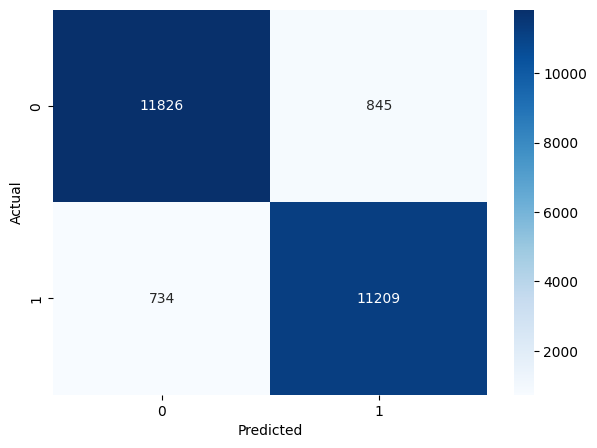

In [6]:
get_predictions(df=race_df, le=le, clf=clf, embeddings_col='embeddings_mini_lm', y_col='difficulty')

In [7]:
# race_df['score_easy'] = clf.predict_proba(X=np.array(race_df['embeddings_mini_lm'].tolist()))[:,0]
# race_df['score_hard'] = clf.predict_proba(X=np.array(race_df['embeddings_mini_lm'].tolist()))[:,1]
# race_df['score_medium'] = clf.predict_proba(X=np.array(race_df['embeddings_mini_lm'].tolist()))[:,2]

# race_df['w_easy_embeddings'] = race_df['embeddings_mini_lm'].apply(lambda x: x * clf.coef_[0])
# race_df['w_hard_embeddings'] = race_df['embeddings_mini_lm'].apply(lambda x: x * clf.coef_[1])
# race_df['w_medium_embeddings'] = race_df['embeddings_mini_lm'].apply(lambda x: x * clf.coef_[2])
# race_df['iw_easy_embeddings'] = race_df['embeddings_mini_lm'].apply(lambda x: x / clf.coef_[0])
# race_df['iw_hard_embeddings'] = race_df['embeddings_mini_lm'].apply(lambda x: x / clf.coef_[1])
# race_df['iw_medium_embeddings'] = race_df['embeddings_mini_lm'].apply(lambda x: x / clf.coef_[2])

race_df['score'] = clf.predict_proba(X=np.array(race_df['embeddings_mini_lm'].tolist()))[:,1]
race_df['w_embeddings'] = race_df['embeddings_mini_lm'].apply(lambda x: x * clf.coef_[0])
race_df['iw_embeddings'] = race_df['embeddings_mini_lm'].apply(lambda x: x / clf.coef_[0])

dolly_cqa_df['score'] = clf.predict_proba(X=np.array(dolly_cqa_df['embeddings_mini_lm'].tolist()))[:,1]
dolly_cqa_df['w_embeddings'] = dolly_cqa_df['embeddings_mini_lm'].apply(lambda x: x * clf.coef_[0])
dolly_cqa_df['iw_embeddings'] = dolly_cqa_df['embeddings_mini_lm'].apply(lambda x: x / clf.coef_[0])

In [8]:
def get_cluster_stats(df, cluster_col, score_col):
    return df.groupby(cluster_col).agg(
        score_mean=pd.NamedAgg(column=score_col, aggfunc='mean'), 
        score_std =pd.NamedAgg(column=score_col, aggfunc='std')
    ).reset_index(drop=False).rename(columns={cluster_col: 'cluster_id'})

n_clusters = 20
seed=0

race_uw_kmeans = KMeans(n_clusters=n_clusters, random_state=seed, n_init="auto").fit( [v for v in race_df['embeddings_mini_lm']])
race_w_kmeans = KMeans(n_clusters=n_clusters, random_state=seed, n_init="auto").fit( [v for v in race_df['w_embeddings']])
race_iw_kmeans = KMeans(n_clusters=n_clusters, random_state=seed, n_init="auto").fit( [v for v in race_df['iw_embeddings']])

dolly_uw_kmeans = KMeans(n_clusters=n_clusters, random_state=seed, n_init="auto").fit( [v for v in dolly_cqa_df['embeddings_mini_lm']])
dolly_w_kmeans = KMeans(n_clusters=n_clusters, random_state=seed, n_init="auto").fit( [v for v in dolly_cqa_df['w_embeddings']])
dolly_iw_kmeans = KMeans(n_clusters=n_clusters, random_state=seed, n_init="auto").fit( [v for v in dolly_cqa_df['iw_embeddings']])

race_df['uw_kmeans'] = race_uw_kmeans.labels_
race_df['w_kmeans'] = race_w_kmeans.labels_
race_df['iw_kmeans'] = race_iw_kmeans.labels_

dolly_cqa_df['uw_kmeans'] = dolly_uw_kmeans.labels_
dolly_cqa_df['w_kmeans'] = dolly_w_kmeans.labels_
dolly_cqa_df['iw_kmeans'] = dolly_iw_kmeans.labels_

# cs_unweighted = get_cluster_stats(dd2, 'unweighted_kmeans', 'score')
# cs_weighted = get_cluster_stats(dd2, 'weighted_kmeans', 'score')
# cs_inverse_weighted = get_cluster_stats(dd2, 'inverse_weighted_kmeans', 'score')

c:\Users\vilce\AppData\Local\miniconda3\envs\llm_env\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
c:\Users\vilce\AppData\Local\miniconda3\envs\llm_env\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
c:\Users\vilce\AppData\Local\miniconda3\envs\llm_env\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(


In [9]:
race_cluster_df = race_df[['uw_kmeans', 'w_kmeans', 'iw_kmeans', 'score']]
race_cluster_df = pd.melt(race_cluster_df, id_vars=['score'], var_name='weighting', value_name='cluster_id')
race_cluster_df = race_cluster_df.groupby(["weighting", "cluster_id"]).mean().reset_index()

dolly_cluster_df = dolly_cqa_df[['uw_kmeans', 'w_kmeans', 'iw_kmeans', 'score']]
dolly_cluster_df = pd.melt(dolly_cluster_df, id_vars=['score'], var_name='weighting', value_name='cluster_id')
dolly_cluster_df = dolly_cluster_df.groupby(["weighting", "cluster_id"]).mean().reset_index()

[Text(0, 0.5, '')]

c:\Users\vilce\AppData\Local\miniconda3\envs\llm_env\Lib\site-packages\IPython\core\pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\vilce\AppData\Local\miniconda3\envs\llm_env\Lib\site-packages\IPython\core\pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\vilce\AppData\Local\miniconda3\envs\llm_env\Lib\site-packages\IPython\core\pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\vilce\AppData\Local\miniconda3\envs

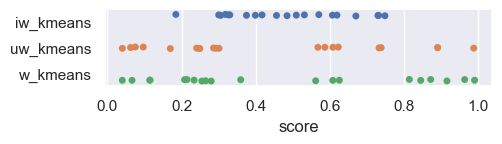

In [10]:
sns.set(rc={"figure.figsize":(5, 1)})
ax = sns.stripplot(x='score', y='weighting', data=race_cluster_df, jitter=True, hue='weighting', dodge=True, legend=False)
ax.set(ylabel=None)

In [11]:
race_cluster_df[['weighting', 'score']].groupby('weighting').std() # standard deviation of mean scores across clusters

,score
weighting,
iw_kmeans,0.166535
uw_kmeans,0.306882
w_kmeans,0.333887


c:\Users\vilce\AppData\Local\miniconda3\envs\llm_env\Lib\site-packages\IPython\core\pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\vilce\AppData\Local\miniconda3\envs\llm_env\Lib\site-packages\IPython\core\pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\vilce\AppData\Local\miniconda3\envs\llm_env\Lib\site-packages\IPython\core\pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\vilce\AppData\Local\miniconda3\envs

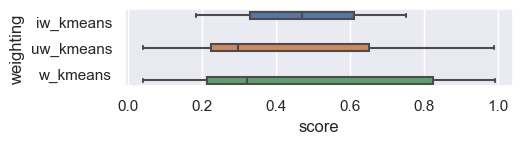

In [12]:
g = sns.boxplot(x='score', y ='weighting', data = race_cluster_df, hue ='weighting')
g.legend([],[], frameon=False)

[Text(0, 0.5, '')]

c:\Users\vilce\AppData\Local\miniconda3\envs\llm_env\Lib\site-packages\IPython\core\pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\vilce\AppData\Local\miniconda3\envs\llm_env\Lib\site-packages\IPython\core\pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\vilce\AppData\Local\miniconda3\envs\llm_env\Lib\site-packages\IPython\core\pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\vilce\AppData\Local\miniconda3\envs

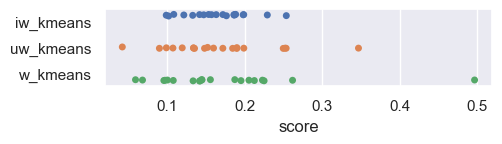

In [13]:
sns.set(rc={"figure.figsize":(5, 1)})
ax = sns.stripplot(x='score', y='weighting', data=dolly_cluster_df, jitter=True, hue='weighting', dodge=True, legend=False)
ax.set(ylabel=None)

In [14]:
dolly_cluster_df[['weighting', 'score']].groupby('weighting').std() # standard deviation of mean scores across clusters

,score
weighting,
iw_kmeans,0.040927
uw_kmeans,0.069550
w_kmeans,0.094920


c:\Users\vilce\AppData\Local\miniconda3\envs\llm_env\Lib\site-packages\IPython\core\pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\vilce\AppData\Local\miniconda3\envs\llm_env\Lib\site-packages\IPython\core\pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\vilce\AppData\Local\miniconda3\envs\llm_env\Lib\site-packages\IPython\core\pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\vilce\AppData\Local\miniconda3\envs

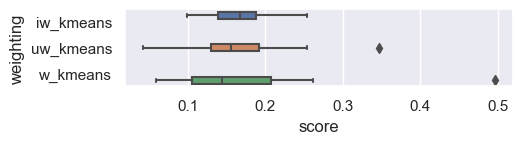

In [15]:
g = sns.boxplot(x='score', y ='weighting', data = dolly_cluster_df, hue ='weighting')
g.legend([],[], frameon=False)